In [1]:
import pickle
import torch
import numpy as np
import os
import re
import json
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def load_pickle(filename: str):
    with open(filename, "rb") as outp:
        obj = pickle.load(outp)
    return obj

In [3]:
def load_json(filename: str) -> dict:
    return json.load(
        open(
            filename,
            "r",
            encoding="utf-8",
        )
    )

# Exploration analysis

Possible questions, fixing delta multiplier and experiment type (in terms of repetitions too):

- How much are we exploring? This has to be studied both generally and fixing the number of explored patches and the type of algorithm
    - delta values at each iteration
    - embedding difference at each iteration

- How much time does experiments take?

TODOS:

- info on dynamic type warping metric
- simec/simexp comparison
- number of patches vs attribution vs delta

In [4]:
experiments_path = "../../res"  # path to exploration results directory
data_path = "../../data"  # path to input data used in experiments

In [33]:
def collect_pkl_res_files(exploration_result_dir: str) -> list:
    """
    Collects paths to all `.pkl` files in a given exploration result directory.

    Parameters:
    ----------
    exploration_result_dir : str
        The root directory to search for `.pkl` files.

    Returns:
    --------
    list
        A list of paths to `.pkl` files found in the directory tree, without considering min and max distribution files.
    """
    pkl_paths = []
    for root, _, files in os.walk(exploration_result_dir):
        # Filter and collect only `.pkl` files
        pkl_paths.extend(
            os.path.join(root, f)
            for f in files
            if f.lower().endswith(".pkl") and "distribution" not in f
        )
    return pkl_paths


def extract_info(file_path: str) -> dict:
    """
    Extracts information from the file path.

    Parameters:
    ----------
    file_path : str
        File path string in the format '../../res/<dataset>-<delta_multiplier>-<extra_number>-<patch_option>-<datetime>/<algorithm>-<input_name>-<repetition>/<iteration>.pkl'

    Returns:
    --------
    dict
        A dictionary with extracted details: dataset, delta_multiplier, patch_option, time, algorithm,
        input_name, repetition, and the datetime object for the timestamp.
    """
    try:
        # Normalize path and split components
        file_path = os.path.normpath(file_path)
        parts = file_path.split(os.sep)

        # Extract the last three components
        iteration_part = parts[-1]
        algorithm_input_repetition_part = parts[-2]
        dataset_part = parts[-3]

        # Parse the iteration part
        iteration = int(iteration_part.split(".")[0])

        # Parse the dataset part
        dataset_info = dataset_part.split("-")
        dataset_name = dataset_info[0]
        delta_multiplier = int(dataset_info[1])
        patch_option = dataset_info[3]
        if "target" in patch_option:
            patch_option = "target-word"
            timestamp_str = dataset_info[5] + "-" + dataset_info[6]
        else:
            timestamp_str = dataset_info[4] + "-" + dataset_info[5]
        timestamp = datetime.strptime(timestamp_str, "%Y%m%d-%H%M%S")

        # Parse the algorithm/input/repetition part
        algorithm, input_name, repetition = algorithm_input_repetition_part.split("-")
        repetition = int(repetition)

        # Return extracted information as a dictionary
        return {
            "dataset_name": dataset_name,
            "delta_multiplier": delta_multiplier,
            "patch_option": patch_option,
            "datetime": timestamp,
            "algorithm": algorithm,
            "input_name": input_name,
            "repetition": repetition,
            "iteration": iteration,
        }
    except Exception as e:
        print(f"Error parsing file path: {file_path}")
        raise ValueError("File path does not match the expected format.") from e


def process_experiment_data(experiments_paths: list, datasets_paths: list):
    # Helper function to process a single experiment file and update the results dictionary
    def extract_pickle_info(file):
        experiment = load_pickle(file)
        experiments["time"].append(experiment.get("time", None))
        experiments["distance"].append(experiment["distance"].detach().numpy())
        experiments["delta"].append(experiment["delta"].detach().numpy().item())
        experiments["input_embedding"].append(
            experiment["input_embedding"].detach().numpy()
        )
        experiments["output_embedding"].append(
            experiment["output_embedding"].detach().numpy()
        )

    def extract_filename_info(file):
        experiment = extract_info(file_path=file)
        for k, v in experiment.items():
            experiments[k].append(v)
        return (
            experiment["input_name"],
            experiment["dataset_name"],
            experiment["patch_option"],
        )

    def collect_attribution(dataset_name: str, input_name: str, patch_option: str):
        for root, _, f in os.walk(datasets_paths):
            if dataset_name == "hatespeech":
                name = "hate-speech"
            elif dataset_name == "winobias":
                name = "wino_bias"
            else:
                name = dataset_name
            if name in root:
                if input_name in [f_n.split(".")[0] for f_n in f]:
                    config = load_json(
                        os.path.join(root, f"config_{patch_option}.json"),
                    )
                    attribution_dict[f"{input_name}-{dataset_name}-{patch_option}"] = (
                        np.array(config[input_name]["attrib"])
                    )
                    return np.array(config[input_name]["attrib"])

    # Initialize dictionary to store experiment results
    experiments = {
        "dataset_name": [],
        "algorithm": [],
        "input_name": [],
        "iteration": [],
        "distance": [],
        "delta": [],
        "delta_multiplier": [],
        "repetition": [],
        "patch_option": [],
        "patch_attribution": [],
        "patches_number": [],
        "input_embedding": [],
        "output_embedding": [],
        "time": [],
        "datetime": [],
    }

    # Initialize dictionary to store attribution for processed instances
    attribution_dict = {}

    # Loop through experiment paths and files, updating the results dictionary
    for file in experiments_paths:
        if "stats" not in file:
            input_name, dataset_name, patch_option = extract_filename_info(file)
            extract_pickle_info(file)
            if patch_option != "target-word":
                attrib = attribution_dict.get(
                    f"{input_name}-{dataset_name}-{patch_option}", None
                )
                if attrib is None:
                    attrib = collect_attribution(
                        dataset_name=dataset_name,
                        input_name=input_name,
                        patch_option=patch_option,
                    )
                experiments["patch_attribution"].append(attrib)
                experiments["patches_number"].append(len(attrib))
            else:
                experiments["patch_attribution"].append(None)
                experiments["patches_number"].append(1)

    # Convert to DataFrame
    return pd.DataFrame.from_dict(experiments)

In [34]:
result_files = collect_pkl_res_files(exploration_result_dir=experiments_path)
experiments_df = process_experiment_data(
    experiments_paths=result_files, datasets_paths=data_path
)

In [36]:
experiments_df

,dataset_name,algorithm,input_name,iteration,distance,delta,delta_multiplier,repetition,patch_option,patch_attribution,patches_number,input_embedding,output_embedding,time,datetime
0,mnist,simexp,img_1599,9,"[7.098564e-10, -2.1509283e-10, 0.0, 3.1373006e...",0.813966,1,1,q2,"[0.25685352087020874, 0.25533512234687805, 0.1...",98,"[[[0.13621905, 0.4324006, 0.3459665, 0.3657204...","[[[0.81297207, 1.5441302, 1.8260574, -3.711027...",NaN,2024-11-21 14:33:28
1,mnist,simexp,img_1599,8,"[7.880611e-10, -2.4356414e-10, 0.0, 2.8737269e...",0.816078,1,1,q2,"[0.25685352087020874, 0.25533512234687805, 0.1...",98,"[[[0.13621905, 0.4324006, 0.3459665, 0.3657204...","[[[0.8205178, 1.5473078, 1.8318932, -3.723444,...",NaN,2024-11-21 14:33:28
2,mnist,simexp,img_1599,10,"[7.098564e-10, -2.1509283e-10, 0.0, 3.1373006e...",0.813966,1,1,q2,"[0.25685352087020874, 0.25533512234687805, 0.1...",98,"[[[0.13621905, 0.4324006, 0.3459665, 0.3657204...","[[[0.81297207, 1.5441302, 1.8260574, -3.711027...",2.446901,2024-11-21 14:33:28
3,mnist,simexp,img_1599,6,"[3.5285105e-10, -1.5120548e-10, 0.0, 1.509049e...",0.802019,1,1,q2,"[0.25685352087020874, 0.25533512234687805, 0.1...",98,"[[[0.13621905, 0.4324006, 0.3459665, 0.3657204...","[[[0.8495472, 1.5641079, 1.8361242, -3.734994,...",NaN,2024-11-21 14:33:28
4,mnist,simexp,img_1599,7,"[5.792371e-10, -2.4739744e-10, 0.0, 2.0149388e...",0.824425,1,1,q2,"[0.25685352087020874, 0.25533512234687805, 0.1...",98,"[[[0.13621905, 0.4324006, 0.3459665, 0.3657204...","[[[0.8367587, 1.5517917, 1.8386805, -3.7347817...",NaN,2024-11-21 14:33:28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13889,hatespeech,simexp,sentence_58345,4,"[2.6861517e-05, -2.5260845e-09, -1.553121e-09,...",0.293697,5,1,all,[],0,"[[[0.18701671, 0.008141014, 0.005842014, 0.032...","[[[-0.33875638, -0.32844144, 0.57941663, -0.59...",NaN,2024-11-21 11:39:27
13890,hatespeech,simexp,sentence_58345,0,"[-1.159674e-09, -1.1943916e-09, -1.2616425e-09...",1.044035,5,1,all,[],0,"[[[0.19159316, 0.00038809807, 0.0017587286, 0....","[[[-0.29139578, -0.283898, 0.5490505, -0.55773...",NaN,2024-11-21 11:39:27
13891,hatespeech,simexp,sentence_58345,1,"[8.6230244e-07, -1.7098489e-09, -1.4614171e-09...",0.310134,5,1,all,[],0,"[[[0.19469541, 0.00038809807, 0.0017587286, 0....","[[[-0.313417, -0.30566558, 0.56540006, -0.5807...",NaN,2024-11-21 11:39:27
13892,hatespeech,simexp,sentence_58345,3,"[8.482582e-06, -2.3019677e-09, -1.7071561e-09,...",0.294134,5,1,all,[],0,"[[[0.18510845, 0.0028891135, 0.0017587286, 0.0...","[[[-0.33481503, -0.32438657, 0.57827485, -0.59...",NaN,2024-11-21 11:39:27


In [37]:
experiments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13894 entries, 0 to 13893
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   dataset_name       13894 non-null  object        
 1   algorithm          13894 non-null  object        
 2   input_name         13894 non-null  object        
 3   iteration          13894 non-null  int64         
 4   distance           13894 non-null  object        
 5   delta              13894 non-null  float64       
 6   delta_multiplier   13894 non-null  int64         
 7   repetition         13894 non-null  int64         
 8   patch_option       13894 non-null  object        
 9   patch_attribution  13013 non-null  object        
 10  patches_number     13894 non-null  int64         
 11  input_embedding    13894 non-null  object        
 12  output_embedding   13894 non-null  object        
 13  time               1294 non-null   float64       
 14  dateti

Text(0.5, 1.0, 'Delta per iteration')

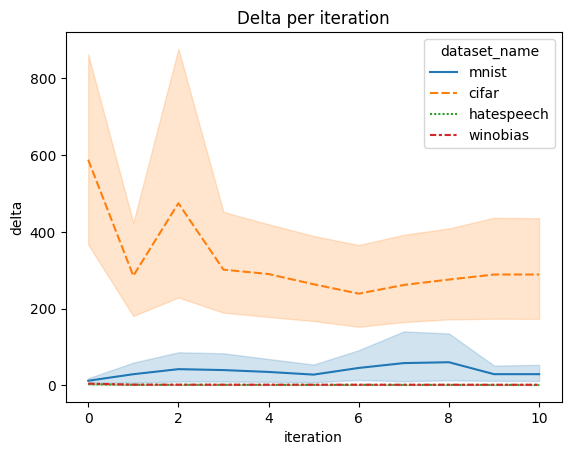

In [41]:
sns.lineplot(
    data=experiments_df,
    x="iteration",
    y="delta",
    style="dataset_name",
    hue="dataset_name",
).set_title("Delta per iteration")

Deltas could be strange because of capping range and non - normalized input values (especially for images).

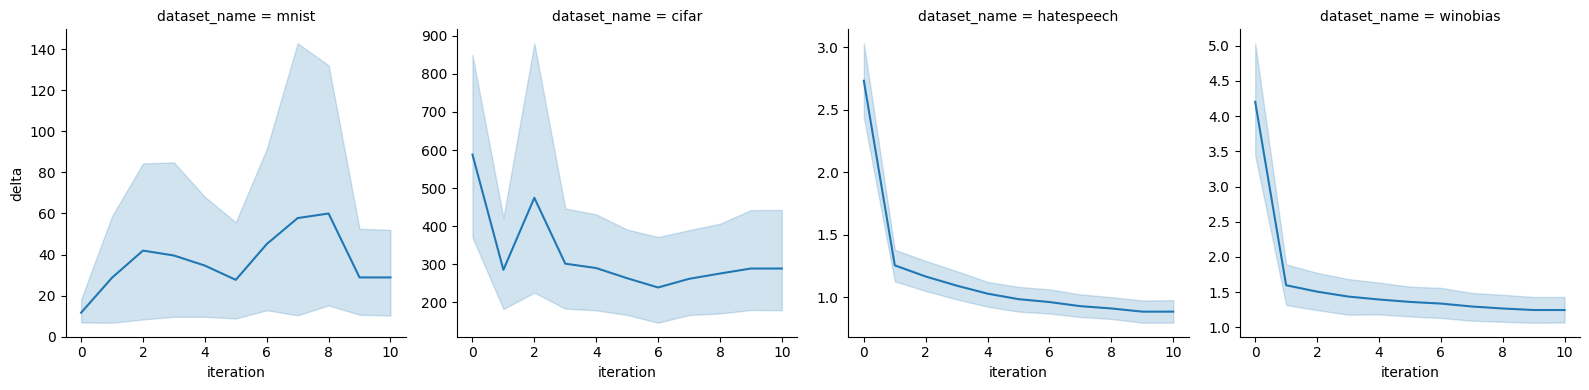

In [45]:
p = sns.FacetGrid(experiments_df, col="dataset_name", sharey=False, height=4, aspect=1)
p.map(
    sns.lineplot,
    "iteration",
    "delta",
)

## CIFAR experiments, delta multiplier = 1

In [ ]:
exp_type, delta = "cifar", 1
n_inputs = 10  # here we consider experiments repeated once (hence, 10 inputs per experiment), except for one input instance. Set to 2 if considering experiments repeated 5 times